# Comparing the Compressible Solvers

Here we'll compare how different compressible solvers perform when run with the same problem setup.

In [1]:
from pyro import Pyro

## Rayleigh-Taylor

The `rt` setup initializes a single-mode Rayleigh-Taylor instability.

To start, let's just run with problem with the `compressible` solver and look at the default parameters.

In [2]:
p = Pyro("compressible")
p.initialize_problem("rt")
print(p)

Solver = compressible
Problem = rt
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = -1.0
compressible.limiter = 2
compressible.riemann = HLLC
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 10000
driver.tmax = 3.0
driver.verbose = 0
eos.gamma = 1.4
io.basename = rt_
io.do_io = 0
io.dt_out = 0.1
io.force_final_output = 0
io.n_out = 100
mesh.grid_type = Cartesian2d
mesh.nx = 64
mesh.ny = 192
mesh.xlboundary = periodic
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.ylboundary = hse
mesh.ymax = 3.0
mesh.ymin = 0.0
mesh.yrboundary = hse
particles.do_particles = 0
particles.n_particles = 100
particles.particle_generator = grid
rt.amp = 0.25
rt.dens1 = 1.0
rt.dens2 = 2.0
rt.p0 = 10.0
rt.sigma = 0.1
vis.dovis = 0
vis.store_im

/raid/zingale/development/pyro2/pyro/compressible/problems/rt.py:71: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]


We see the default grid is $64\times 192$ zones, periodic in the $x$ direction, and hydrostatic boundary conditions vertically.  We note that the HSE BCs are not designed for the 4th order solvers, so we will need to switch to reflecting boundaries for that solver.

Now we can run and look at the output.  This can take a while...

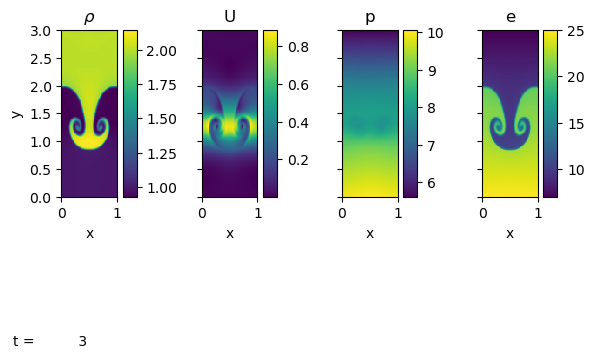

<Figure size 640x480 with 0 Axes>

In [3]:
p.run_sim()
p.sim.dovis()

### Comparisons

To speed up the comparison, we'll use a coarser grid.  The amount of work in 2D scales like $\mathcal{O}(N^3)$ (where the additional power comes from the timestep constraint).  So cutting the number of zones in half will run 8 times faster.

We'll append the `Pyro` objects to the `runs` list as we do the simulations.

In [4]:
runs = []
solvers = ["compressible", "compressible_rk", "compressible_fv4"]

We'll override the default number of cells for the `rt` problem to make it smaller (and run faster).

In [5]:
params = {"mesh.nx": 32, "mesh.ny": 96}

Now we loop over the solvers, setup the `Pyro` object and run the simulations.

In [6]:
for s in solvers:
    p = Pyro(s)
    extra_params = {}
    if s == "compressible_fv4":
        extra_params = {"mesh.ylboundary": "reflect", "mesh.yrboundary": "reflect"}
    p.initialize_problem(problem_name="rt", inputs_dict=params|extra_params)
    p.run_sim()
    runs.append(p)

/raid/zingale/development/pyro2/pyro/compressible/problems/rt.py:71: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]
/raid/zingale/development/pyro2/pyro/compressible_rk/problems/rt.py:71: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]
/raid/zingale/development/pyro2/pyro/compressible_fv4/problems/rt.py:71: RuntimeWarning: invalid value encountered in divide
  0.5*(xmom[:, :]**2 + ymom[:, :]**2)/dens[:, :]


Finally, we'll plot them.  We'll just look at the density and put them all on the same set of axes.
Since our data is stored as $\rho(x, y)$, `imshow()` will want to put $x$ on the vertical axis, so
we transpose the data before plotting.  We also want to exclude the ghost cells, so we use `rho.v()`.

In [7]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

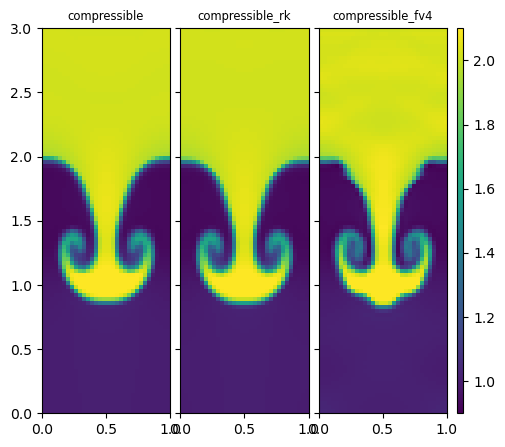

In [8]:
fig = plt.figure(figsize=(7, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(runs)), axes_pad=0.1,
                 share_all=True, cbar_mode="single", cbar_location="right")

for ax, s, p in zip(grid, solvers, runs):
    rho = p.get_var("density")
    g = p.get_grid()
    im = ax.imshow(rho.v().T,
                   extent=[g.xmin, g.xmax, g.ymin, g.ymax],
                   origin="lower", vmin=0.9, vmax=2.1)
    ax.set_title(s, fontsize="small")
grid.cbar_axes[0].colorbar(im)

We see that the 4th order solver has more structure at fine scales (this becomes even more apparently at higher resolutions).

## Kelvin-Helmholtz

The Kelvin-Helmholtz instability arises from a shear layer.
[McNally et al. 2012](https://iopscience.iop.org/article/10.1088/0067-0049/201/2/18) describe a version of KH that is
boosted, to understand how numerical dissipation affects the growth of the instability.  The initial conditions
set up a heavier fluid moving in the negative x-direction sandwiched between regions of lighter fluid moving in the positive x-direction.  A bulk
velocity can be applied in the vertical direction.

Again, we'll start by looking at the defaults.

In [9]:
p = Pyro("compressible")
p.initialize_problem("kh")
print(p)

Solver = compressible
Problem = kh
Simulation time = 0.0
Simulation step number = 0

Runtime Parameters
------------------
compressible.cvisc = 0.1
compressible.delta = 0.33
compressible.grav = 0.0
compressible.limiter = 2
compressible.riemann = HLLC
compressible.use_flattening = 1
compressible.z0 = 0.75
compressible.z1 = 0.85
driver.cfl = 0.8
driver.fix_dt = -1.0
driver.init_tstep_factor = 0.01
driver.max_dt_change = 2.0
driver.max_steps = 5000
driver.tmax = 2.0
driver.verbose = 0
eos.gamma = 1.4
io.basename = kh_
io.do_io = 0
io.dt_out = 0.1
io.force_final_output = 0
io.n_out = 10000
kh.bulk_velocity = 0.0
kh.rho_1 = 1
kh.rho_2 = 2
kh.u_1 = -0.5
kh.u_2 = 0.5
mesh.grid_type = Cartesian2d
mesh.nx = 64
mesh.ny = 64
mesh.xlboundary = periodic
mesh.xmax = 1.0
mesh.xmin = 0.0
mesh.xrboundary = periodic
mesh.ylboundary = periodic
mesh.ymax = 1.0
mesh.ymin = 0.0
mesh.yrboundary = periodic
particles.do_particles = 0
particles.n_particles = 100
particles.particle_generator = grid
vis.dovis = 0

Now let's run the different solvers with a bulk velocity of 3

In [10]:
runs = []
solvers = ["compressible", "compressible_rk", "compressible_fv4"]
params = {"mesh.nx": 96, "mesh.ny": 96,
          "kh.bulk_velocity": 3.0}

In [11]:
for s in solvers:
    p = Pyro(s)
    p.initialize_problem(problem_name="kh", inputs_dict=params)
    p.run_sim()
    runs.append(p)

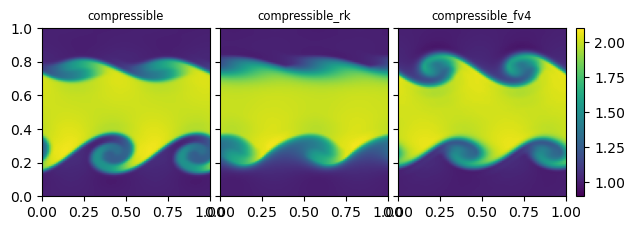

In [12]:
fig = plt.figure(figsize=(7, 5))
grid = ImageGrid(fig, 111, nrows_ncols=(1, len(runs)), axes_pad=0.1,
                 share_all=True, cbar_mode="single", cbar_location="right")

for ax, s, p in zip(grid, solvers, runs):
    rho = p.get_var("density")
    g = p.get_grid()
    im = ax.imshow(rho.v().T,
                   extent=[g.xmin, g.xmax, g.ymin, g.ymax],
                   origin="lower", vmin=0.9, vmax=2.1)
    ax.set_title(s, fontsize="small")
grid.cbar_axes[0].colorbar(im)

Here we see that for the second-order solvers, the growth of the instability at the top interface is very diffusive.  It is better in the unsplit CTU version than in the Runge-Kutta solver.

The 4th order compressible solver looks the best, with well-defined rolls on both the top and bottom interface.  This solver does even better at higher resolution--when the resolution is coarse, the averaging of the initial conditions from cell-centers to cell-averages in the 4th order solver seems to smear the perturbation out more.